# Global imports

In [1]:
import os
import shutil
import requests
import zipfile
import warnings
from typing import List, Tuple, TypeAlias
from time import time as tt
from dataclasses import replace

import equinox as eqx
import jax.numpy as jnp
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import matplotlib as mpl
from matplotlib.pyplot import Figure, Axes
from jax import block_until_ready, clear_caches

subplot_1D_type: TypeAlias = Tuple[Figure, List[Axes]]
subplot_2D_type: TypeAlias = Tuple[Figure, List[List[Axes]]]
latex_installed = shutil.which("latex") is not None
plt.rcParams.update({
    'text.usetex': latex_installed,
    'figure.figsize': (8, 5),
    'axes.titlesize': 18,
    'figure.titlesize': 18,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'lines.linewidth': 2,
    'lines.markersize': 15
})
def set_xlim(ax: Axes, xmin: float, xmax: float, border: float=0.02):
    xmin_margin =  xmin - (xmax-xmin)*border
    xmax_margin =  xmax + (xmax-xmin)*border
    ax.set_xlim(xmin_margin, xmax_margin)
def set_ylim(ax: Axes, ymin: float, ymax: float, border: float=0.02):
    ymin_margin =  ymin - (ymax-ymin)*border
    ymax_margin =  ymax + (ymax-ymin)*border
    ax.set_ylim(ymin_margin, ymax_margin)

# Wagner's LES
[Wagner's valibration repository](https://github.com/glwagner/SingleColumnModelCalibration.jl?tab=readme-ov-file)

## Download

In [2]:
do_run = False
if do_run:
    url = 'https://www.dropbox.com/scl/fi/8qwe9hf6wxc3w0crhzpml/profiles.zip?rlkey=sm8f7rhfokitzc7cgwinhip2k'
    url = url + '&dl=1'
    archive_file_name = 'tmp.zip'
    response = requests.get(url, allow_redirects=True)
    with open(archive_file_name, 'wb') as file:
        file.write(response.content)
    with zipfile.ZipFile(archive_file_name, 'r') as zipf:
        zipf.extractall()
    os.remove(archive_file_name)

## Global variables

In [3]:
LES_TIMEFRAMES = [6, 12, 24, 48, 72]
LES_SPACE_STEPS = [1, 2, 4]
LES_FORCINGS = [
    'free_convection',
    'weak_wind_strong_cooling',
    'med_wind_med_cooling',
    'strong_wind_weak_cooling',
    'strong_wind',
    'strong_wind_no_rotation',
    'strong_wind_and_sunny'
]
N_LES_T = len(LES_TIMEFRAMES)
N_LES_S = len(LES_SPACE_STEPS)
N_LES_F = len(LES_FORCINGS)

# link between Wagner's and Tunax names of the variables
LES_VAR_NAMES = {
    'variables': {
        'time': 'timeseries/t',
        'zr': 'grid/zᵃᵃᶜ',
        'zw': 'grid/zᵃᵃᶠ',
        'u': 'timeseries/u',
        'v': 'timeseries/v',
        'b': 'timeseries/b',
        'pt': 'timeseries/c'
    },
    'parameters': {
        'nz': 'grid/Nz',
        'fcor': 'parameters/coriolis_parameter'
    },
    'metadatas': {
        'u_str': 'parameters/momentum_flux',
        'b_str': 'parameters/buoyancy_flux',
        'pt_depth': 'parameters/tracer_forcing_depth',
        'pt_timescale': 'parameters/tracer_forcing_timescale',
        'pt_width': 'parameters/tracer_forcing_width',
        'sunny_flux': 'parameters/penetrating_buoyancy_flux'
    }
}

# on which dimensions load the variables
LES_DIMS = {
    'zr': (None,),
    'zw': (None,),
    'u': (None, 0, 0),
    'v': (None, 0, 0),
    'b': (None, 0, 0),
    'pt': (None, 0, 0)
}

LES_PATH = 'Wagner_LES'

OUTPUTS_PATH = 'benchmark_Wagner_LES'
os.makedirs(OUTPUTS_PATH, exist_ok=True)

## Rename folders and file

In [4]:
do_run = False
if do_run:
    os.rename('profiles', LES_PATH)
    for timeframe in LES_TIMEFRAMES:
        os.rename(os.path.join(LES_PATH, f'{timeframe}_hour_suite'), os.path.join(LES_PATH, f'{timeframe}h'))
        for space_step in LES_SPACE_STEPS:
            for forcing in LES_FORCINGS:
                os.rename(
                    os.path.join(LES_PATH, f'{timeframe}h', f'{space_step}m', f'{forcing}_with_tracer_instantaneous_statistics.jld2'),
                    os.path.join(LES_PATH, f'{timeframe}h', f'{space_step}m', f'{forcing}.jld2')
                )
    os.remove(os.path.join(LES_PATH, 'getsuite.sh'))

## Forcings

In [5]:
def forcing_passive_tracer(
        z: float,
        omega_p: float,
        lambda_c: float,
        zc: float,
        l_z: float
    ):
    omega_m = omega_p*lambda_c*jnp.sqrt(2*jnp.pi)/l_z
    fz = omega_p*jnp.exp(-(z-zc)**2/(2*lambda_c**2)) + omega_m
    return  fz

def forcing_buoyancy_sunny(
        z: float,
        jb: float,
        eps1: float,
        lambda1: float,
        lambda2: float,
    ):
    fz = -jb*(eps1/lambda1*jnp.exp(z/lambda1) + (1-eps1)/lambda2*jnp.exp(z/lambda2))
    return  fz

# Runs directs
## First Tunax implementation
### Computing all simulations

In [ ]:
from tunax import SingleColumnModel as ModelOld
from tunax import Obs as ObsOld
from tunax.closures import KepsParameters as KepsParOld
from tunax_new import SingleColumnModel as ModelNew
from tunax_new import Obs as ObsNew
from tunax_new.closures import KepsParameters as KepsParNew
from tunax_new_case_tracable import SingleColumnModel as ModelNewTracable
from tunax_new_case_tracable import Obs as ObsNewTracable
from tunax_new_case_tracable.closures import KepsParameters as KepsParNewTracable

warnings.filterwarnings("ignore", category=UserWarning)

def benchmark_SingleColumnModel(n_trials: int, dt: float, tunax_version: str, run_method_name: str, experience_name: str):
    runtimes = np.zeros((N_LES_S, N_LES_T, N_LES_F, n_trials))
    compilations = np.zeros((N_LES_S, N_LES_T, N_LES_F, n_trials), dtype=bool)
    output_path = os.path.join('benchmark_Wagner_LES', experience_name)
    runtimes_path = os.path.join(output_path, 'runtimes_apple_M3pro.npy')
    compilations_path = os.path.join(output_path, 'compilations_apple_M3pro.npy')
    os.makedirs(output_path, exist_ok=True)
    match tunax_version:
        case 'tunax':
            ObsClass = ObsOld
            KepsParClass = KepsParOld
        case 'tunax_new':
            ObsClass = ObsNew
            KepsParClass = KepsParNew
        case 'tunax_new_case_tracable':
            ObsClass = ObsNewTracable
            KepsParClass = KepsParNewTracable

    old_cache_size = 0
    pbar = tqdm(total=len(LES_SPACE_STEPS)*len(LES_TIMEFRAMES)*len(LES_FORCINGS), desc='simulation')
    for i_space_step, space_step in enumerate(LES_SPACE_STEPS):
        for i_timeframe, timeframe in enumerate(LES_TIMEFRAMES):
            for i_forcing, forcing in enumerate(LES_FORCINGS):
                jld2_filename = os.path.join(LES_PATH,f'{timeframe}h', f'{space_step}m', f'{forcing}.jld2')
                traj_output_path = os.path.join(output_path, f'{timeframe}h', f'{space_step}m', f'{forcing}.nc')
                os.makedirs(os.path.dirname(traj_output_path), exist_ok = True)
                obs = ObsClass.from_jld2(jld2_filename, LES_VAR_NAMES, None, LES_DIMS, eos_tracers='b', do_pt=True)

                # case corrections
                obs = eqx.tree_at(lambda t: t.case.ustr_sfc, obs, -obs.metadatas['u_str'])
                new_case = replace(obs.case, b_forcing=(0., -obs.metadatas['b_str']))
                obs = eqx.tree_at(lambda t: t.case, obs, new_case)
                obs = eqx.tree_at(lambda t: t.case.grav, obs, 9.80665)

                # passive tracer forcing
                omega_p = 1/obs.metadatas['pt_timescale']
                lambda_c = obs.metadatas['pt_width']
                zc = obs.metadatas['pt_depth']
                l_z = obs.trajectory.grid.hbot
                wrapped_forcing_pt = lambda z: forcing_passive_tracer(z, omega_p, lambda_c, -zc, l_z)
                new_case = replace(obs.case, pt_forcing=wrapped_forcing_pt)
                if tunax_version != 'tunax_new_case_tracable':
                    new_case = replace(new_case, pt_forcing_type='constant')
                obs = eqx.tree_at(lambda t: t.case, obs, new_case)

                # sunny forcing
                if forcing == 'strong_wind_and_sunny':
                    jb = obs.metadatas['sunny_flux']
                    eps1 = 0.6
                    lambda1 = 1.
                    lambda2 = 16.
                    wrapped_forcing_b_sunny = lambda z: forcing_buoyancy_sunny(z, jb, eps1, lambda1, lambda2)
                    new_case = replace(obs.case, b_forcing=wrapped_forcing_b_sunny)
                    if tunax_version != 'tunax_new_case_tracable':
                        new_case = replace(new_case, b_forcing_type='constant')
                    obs = eqx.tree_at(lambda t: t.case, obs, new_case)

                # model instance
                traj_wagner = obs.trajectory
                init_state = traj_wagner.extract_state(0)
                match tunax_version:
                    case 'tunax':
                        timeframe_h = float(traj_wagner.time[-1]/3600)
                        out_dt = float(traj_wagner.time[1] - traj_wagner.time[0])
                        model = ModelOld(timeframe_h, dt, out_dt, init_state, obs.case, 'k-epsilon', traj_output_path)
                    case 'tunax_new':
                        nt = int(timeframe*3600/dt)
                        out_dt = float(traj_wagner.time[1] - traj_wagner.time[0])
                        p_out = int(out_dt/dt)
                        model = ModelNew(nt, dt, p_out, init_state, obs.case, 'k-epsilon')
                    case 'tunax_new_case_tracable':
                        nt = int(timeframe*3600/dt)
                        out_dt = float(traj_wagner.time[1] - traj_wagner.time[0])
                        p_out = int(out_dt/dt)
                        model = ModelNewTracable(nt, dt, p_out, init_state, obs.case, 'k-epsilon')

                # k-epsilon parameters
                keps_params = KepsParClass()

                for i_trial in tqdm(range(n_trials), desc='trials', leave=False):
                    # run the model
                    run_method = getattr(model, run_method_name)
                    start_time = tt()
                    traj = block_until_ready(run_method(keps_params))
                    runtimes[i_space_step, i_timeframe, i_forcing, i_trial] = tt() - start_time
                    if run_method_name in ['jit_run', 'jit_run_final_state']:
                        if run_method._cache_size() > old_cache_size:
                            compilations[i_space_step, i_timeframe, i_forcing, i_trial] = True
                            old_cache_size = run_method._cache_size()

                    # write the times and the cache size
                    np.save(runtimes_path, runtimes)
                    np.save(compilations_path, compilations)
                
                # write the output
                if tunax_version != 'tunax':
                    traj.to_nc(traj_output_path)

                pbar.update(1)
    pbar.close()

In [ ]:
# benchmark_SingleColumnModel(5, 10., 'tunax', 'compute_trajectory_with', 'tunax_default')

simulation:   0%|          | 0/105 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
# benchmark_SingleColumnModel(5, 10., 'tunax_new', 'compute_trajectory_with', 'tridiag_scan')

simulation:   0%|          | 0/105 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
# benchmark_SingleColumnModel(5, 10., 'tunax_new', 'run_jit_step', 'temporal_loop_scan')

simulation:   0%|          | 0/105 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
# benchmark_SingleColumnModel(5, 10., 'tunax_new', 'jit_run', 'jit_outside')

simulation:   0%|          | 0/105 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
# benchmark_SingleColumnModel(5, 10., 'tunax_new', 'jit_run_final_state', 'no_intermediate_outputs')

simulation:   0%|          | 0/105 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
# benchmark_SingleColumnModel(5, 10., 'tunax_new_case_tracable', 'jit_run', 'array_forcings')

simulation:   0%|          | 0/105 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

trials:   0%|          | 0/5 [00:00<?, ?it/s]

### Plot function

In [13]:
titles = {
    'free_convection': 'free convection',
    'weak_wind_strong_cooling': 'weak wind\nstrong cooling',
    'med_wind_med_cooling': 'med wind\nmed cooling',
    'strong_wind_weak_cooling': 'strong wind\nweak cooling',
    'strong_wind': 'strong wind',
    'strong_wind_no_rotation': 'strong wind\nno rotation',
    'strong_wind_and_sunny': 'strong wind sunny\n no rotation'
}

def plot_wag(timeframe: int, space_step: int, output_path: str):
    sp: subplot_2D_type = plt.subplots(3, 7, sharey=True, figsize=(18, 12))
    fig, [axs_b, axs_uv, axs_pt] = sp

    for i_forcing, forcing in enumerate(LES_FORCINGS):
        filename = os.path.join(LES_PATH, f'{timeframe}h', f'{space_step}m', f'{forcing}.jld2')
        wagner_obs = Obs.from_jld2(filename, LES_VAR_NAMES, None, LES_DIMS, eos_tracers='b', do_pt=True)
        wagner_traj = wagner_obs.trajectory
        
        tunax_path = os.path.join(output_path, f'{timeframe}h', f'{space_step}m', f'{forcing}.nc')
        tunax_ds = xr.load_dataset(tunax_path)
        axs_b[i_forcing].plot(wagner_traj.b[0, :], wagner_traj.grid.zr, 'k', linewidth=1)
        axs_b[i_forcing].plot(wagner_traj.b[-1, :], wagner_traj.grid.zr, 'r')
        axs_b[i_forcing].plot(tunax_ds.b[-1, :], wagner_traj.grid.zr, 'g')
        if i_forcing > 0:
            axs_uv[i_forcing].plot(wagner_traj.u[0, :], wagner_traj.grid.zr, 'k', linewidth=1)
            axs_uv[i_forcing].plot(wagner_traj.u[-1, :], wagner_traj.grid.zr, 'r')
            axs_uv[i_forcing].plot(tunax_ds.u[-1, :], wagner_traj.grid.zr, 'g')
            axs_uv[i_forcing].plot(wagner_traj.v[0, :], wagner_traj.grid.zr, 'k--', linewidth=1)
            axs_uv[i_forcing].plot(wagner_traj.v[-1, :], wagner_traj.grid.zr, 'r--')
            axs_uv[i_forcing].plot(tunax_ds.v[-1, :], wagner_traj.grid.zr, 'g--')
        axs_pt[i_forcing].plot(wagner_traj.pt[0, :], wagner_traj.grid.zr, 'k', linewidth=1)
        axs_pt[i_forcing].plot(wagner_traj.pt[-1, :], wagner_traj.grid.zr, 'r')
        axs_pt[i_forcing].plot(tunax_ds.pt[-1, :], wagner_traj.grid.zr, 'g')
        axs_b[i_forcing].set_title(titles[LES_FORCINGS[i_forcing]])
    axs_b[0].set_ylabel(r'$b []$')
    axs_uv[1].set_ylabel(r'$u, v \left[\mathrm m \cdot \mathrm s^{-1}\right]$')
    axs_pt[0].set_ylabel(r'passive tracer $[]$')
    axs_uv[0].plot([], [], 'g', label='tunax')
    axs_uv[0].plot([], [], 'r', label='LES')
    axs_uv[0].plot([], [], 'k', label='u')
    axs_uv[0].plot([], [], 'k--', label='v')
    axs_uv[0].text(-0.0, -40, f'time = {timeframe}h\nspace step = {space_step}m', fontsize=18, horizontalalignment='center')
    axs_uv[0].legend(loc='center')
    axs_uv[0].axis('off')
    axs_b[0].set_ylim(-200, 2)

### Plots

NameError: name 'Obs' is not defined

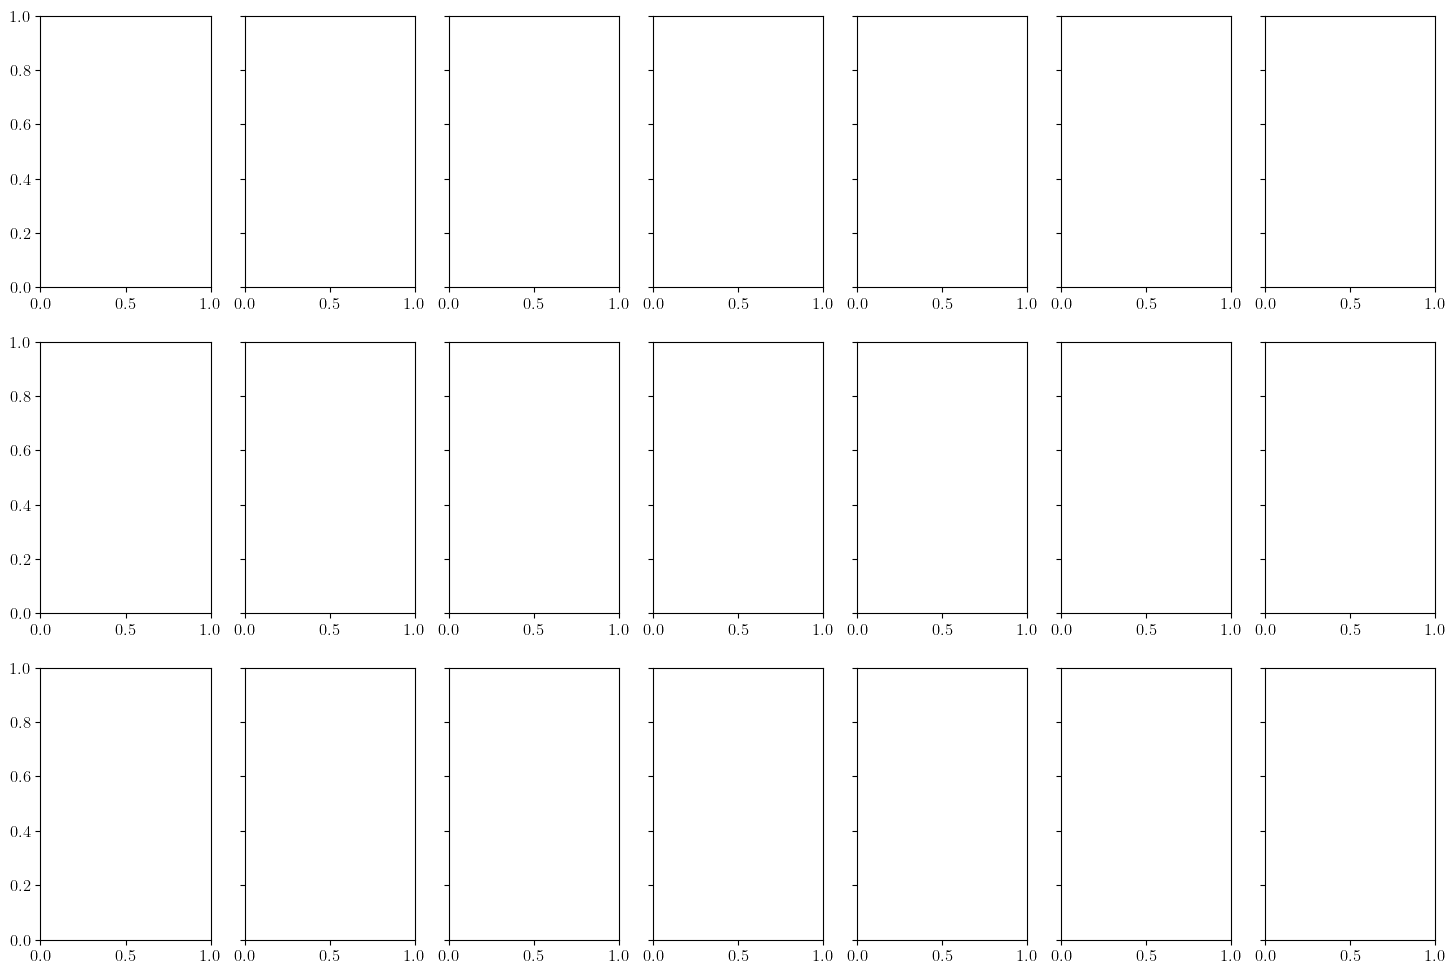

In [14]:
plot_wag(24, 1, os.path.join(OUTPUTS_PATH, 'tunax_default'))

## New implementations
### Benchmark function
Run for the different run methods implemented.

In [ ]:
from tunax import SingleColumnModel2

def benchmark_SingleColumnModel2(n_trials: int, dt: float, run_method_name: str, output_path: str):
    runtimes = np.zeros((N_LES_S, N_LES_T, N_LES_F, n_trials))
    runtimes_path = os.path.join(output_path, 'runtimes_apple_M3pro.npy')
    os.makedirs(output_path, exist_ok=True)

    for i_trial in tqdm(range(n_trials), desc='trials'):
        pbar = tqdm(total=len(LES_SPACE_STEPS)*len(LES_TIMEFRAMES)*len(LES_FORCINGS), desc='simulation', leave=False)
        for i_space_step, space_step in enumerate(LES_SPACE_STEPS):
            for i_timeframe, timeframe in enumerate(LES_TIMEFRAMES):
                clear_caches()
                for i_forcing, forcing in enumerate(LES_FORCINGS):
                    jld2_filename = os.path.join(LES_PATH,f'{timeframe}h', f'{space_step}m', f'{forcing}.jld2')
                    traj_output_path = os.path.join(output_path, f'{timeframe}h', f'{space_step}m', f'{forcing}.nc')
                    os.makedirs(os.path.dirname(traj_output_path), exist_ok = True)
                    obs = Obs.from_jld2(jld2_filename, LES_VAR_NAMES, None, LES_DIMS, eos_tracers='b', do_pt=True)

                    # case corrections
                    obs: Obs = eqx.tree_at(lambda t: t.case.ustr_sfc, obs, -obs.metadatas['u_str'])
                    new_case = replace(obs.case, b_forcing=(0., -obs.metadatas['b_str']))
                    obs: Obs = eqx.tree_at(lambda t: t.case, obs, new_case)
                    obs: Obs = eqx.tree_at(lambda t: t.case.grav, obs, 9.80665)

                    # passive tracer forcing
                    omega_p = 1/obs.metadatas['pt_timescale']
                    lambda_c = obs.metadatas['pt_width']
                    zc = obs.metadatas['pt_depth']
                    l_z = obs.trajectory.grid.hbot
                    wrapped_forcing_pt = lambda z: forcing_passive_tracer(z, omega_p, lambda_c, -zc, l_z)
                    new_case = replace(obs.case, pt_forcing=wrapped_forcing_pt)
                    new_case = replace(new_case, pt_forcing_type='constant')
                    obs: Obs = eqx.tree_at(lambda t: t.case, obs, new_case)

                    # sunny forcing
                    if forcing == 'strong_wind_and_sunny':
                        jb = obs.metadatas['sunny_flux']
                        eps1 = 0.6
                        lambda1 = 1.
                        lambda2 = 16.
                        wrapped_forcing_b_sunny = lambda z: forcing_buoyancy_sunny(z, jb, eps1, lambda1, lambda2)
                        new_case = replace(obs.case, b_forcing=wrapped_forcing_b_sunny)
                        new_case = replace(new_case, b_forcing_type='constant')
                        obs: Obs = eqx.tree_at(lambda t: t.case, obs, new_case)

                    # model instance
                    traj_wagner = obs.trajectory
                    nt = int(timeframe*3600/dt)
                    out_dt = float(traj_wagner.time[1] - traj_wagner.time[0])
                    p_out = int(out_dt/dt)
                    init_state = traj_wagner.extract_state(0)
                    model = SingleColumnModel2(nt, dt, p_out, init_state, obs.case, 'k-epsilon')

                    # k-epsilon parameters
                    keps_params = KepsParameters()

                    # run the model
                    run_method = getattr(model, run_method_name)
                    start_time = tt()
                    traj: Trajectory = block_until_ready(run_method(keps_params))
                    runtimes[i_space_step, i_timeframe, i_forcing, i_trial] = tt() - start_time

                    # write the output
                    if run_method_name != 'jit_run_final_state':
                        traj_ds = traj.to_ds()
                        traj_ds.to_netcdf(traj_output_path)

                    # write the times
                    np.save(runtimes_path, runtimes)

                    pbar.update(1)
        pbar.close()

### Change of the tridiagonal function with `lax.scan`
#### Compute

In [ ]:
do_run = False
if do_run:
    benchmark_SingleColumnModel2(5, 10., 'compute_trajectory_with', os.path.join(OUTPUTS_PATH, 'tridiag_scan'))

28 minutes Macbook
#### Plots

In [ ]:
plot_wag(24, 1, os.path.join(OUTPUTS_PATH, 'tridiag_scan'))

### Change of the integration loop with `lax.scan`
#### Compute

In [ ]:
do_run = False
if do_run:
    benchmark_SingleColumnModel2(5, 10., 'run_jit_step', os.path.join(OUTPUTS_PATH, 'temporal_loop_scan'))

18 minutes Macbook.
#### Plots

In [ ]:
plot_wag(24, 1, os.path.join(OUTPUTS_PATH, 'temporal_loop_scan'))

### Put the `jit` on the whole model
#### Compute

In [ ]:
do_run = False
if do_run:
    benchmark_SingleColumnModel2(5, 10., 'jit_run', os.path.join(OUTPUTS_PATH, 'jit_outside'))

18 minutes sur Macbook
#### Plots

In [ ]:
plot_wag(24, 1, os.path.join(OUTPUTS_PATH, 'jit_outside'))

### Remove the intermediates outputs
#### Compute

In [ ]:
do_run = False
if do_run:
    benchmark_SingleColumnModel2(5, 10., 'jit_run_final_state', os.path.join(OUTPUTS_PATH, 'no_intermediate_outputs'))

## Runtimes
### Compilation effect
Here we visualise the evolution of 

In [ ]:
method_list = ['tunax_default', 'tridiag_scan', 'temporal_loop_scan', 'jit_outside', 'no_intermediate_outputs']
cmap = mpl.colormaps['Set1']
colors_by_method = {method: cmap(i_method/len(method_list)) for i_method, method in enumerate(method_list)}

In [ ]:
runtime_file_name = 'runtimes_apple_M3pro.npy'
runtimes_by_method = {method: np.load(os.path.join(OUTPUTS_PATH, method, runtime_file_name)) for method in method_list}
runtime_jit_means = {method: {timeframe: {space_step: np.zeros(1) for space_step in LES_SPACE_STEPS} for timeframe in LES_TIMEFRAMES} for method in method_list}
runtime_compilation_means = {method: {timeframe: {space_step: np.zeros(1) for space_step in LES_SPACE_STEPS} for timeframe in LES_TIMEFRAMES} for method in method_list}
for i_space_step, space_step in enumerate(LES_SPACE_STEPS):
    for i_timeframe, timeframe in enumerate(LES_TIMEFRAMES):
        for method in method_list:
            runtime_jit_means[method][timeframe][space_step] = np.mean(runtimes_by_method[method][i_space_step, i_timeframe, 1:, :])
            runtime_compilation_means[method][timeframe][space_step] = np.mean(runtimes_by_method[method][i_space_step, i_timeframe, 0, :])

In [ ]:
width_method = .1
width_timeframe = width_method*(len(method_list)+1)
width_space_step = width_timeframe*(len(LES_TIMEFRAMES)+1)
fig, ax = plt.subplots()

for i_space_step, space_step in enumerate(LES_SPACE_STEPS[::-1]):
    ax.text(i_space_step*width_space_step + width_timeframe*2+width_method*2, -3, 256//space_step, fontsize=15, horizontalalignment='center')
    for i_timeframe, timeframe in enumerate(LES_TIMEFRAMES):
        ax.text(i_space_step*width_space_step + width_timeframe*i_timeframe+width_method*2, -1.5, timeframe*3600//10, fontsize=10, horizontalalignment='center')
        for i_method, method in enumerate(method_list):
            plt.bar(i_space_step*width_space_step + width_timeframe*i_timeframe + width_method*i_method, runtime_jit_means[method][timeframe][space_step], width=width_method, color=colors_by_method[method])
for i_method, method in enumerate(method_list):
    plt.bar(0, 0, color=colors_by_method[method], label=method)
ax.legend()
ax.set_ylabel('runtime mean [s]')
ax.set_xlim(-.2, 10.2)
# ax.set_xticks([])
ax.text(-1, -1.5, 'time steps', fontsize=10, horizontalalignment='center')
_ = ax.text(-1, -3, 'space steps', fontsize=15, horizontalalignment='center')

# Gradients